## 1. First Section- Data

 -   1.1 Introduce Data <br>
 以下為Data來源:<br><br>
 [可口可樂公司的股票](https://www.morningstar.com/stocks/xnys/ko/quote "Coca-Cola")
>可口可樂是一家跨國無酒精飲料生產、銷售商，也是世界第一個可樂品牌。

 -   1.2 Visualizing and Munging Stock Data

In [1]:
# 匯入引用的套件
import os
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# 使用yfinance套件匯入可口可樂公司的股票數據，資料期間為2019-01-01 ~ 2021-06-01
CocaCola = yf.download("KO", start="2019-01-01", end="2021-06-01",group_by="ticker") 
print(CocaCola)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-12-31  47.490002  47.540001  46.959999  47.349998  43.681664  10576300
2019-01-02  46.939999  47.220001  46.560001  46.930000  43.294197  11603700
2019-01-03  46.820000  47.369999  46.529999  46.639999  43.026661  14714400
2019-01-04  46.750000  47.570000  46.639999  47.570000  43.884617  13013700
2019-01-07  47.570000  47.750000  46.900002  46.950001  43.312645  13135500
...               ...        ...        ...        ...        ...       ...
2021-05-24  54.630001  54.930000  54.490002  54.799999  54.390167  10326100
2021-05-25  54.820000  54.820000  54.349998  54.790001  54.380245  11916500
2021-05-26  54.980000  55.049999  54.590000  55.029999  54.618450  16064300
2021-05-27  55.209999  55.570000  54.779999  55.490002  55.075012  59109600
2021-05-28  55.3499

In [3]:
# 查看數據集分佈的集中趨勢、分散和形狀的統計，不包括NaN值
CocaCola.describe()

,Open,High,Low,Close,Adj Close,Volume
count,608.000000,608.000000,608.000000,608.000000,608.000000,6.080000e+02
mean,50.646957,51.051480,50.211398,50.626990,48.479875,1.535602e+07
std,3.762875,3.712815,3.860141,3.808292,3.929899,7.654306e+06
min,38.759998,38.889999,36.270000,37.560001,36.061562,3.265500e+06
25%,47.754999,48.072501,47.145001,47.669999,45.124847,1.071108e+07
50%,50.580000,51.105000,50.145000,50.635000,48.856136,1.361705e+07
75%,53.752500,54.054999,53.284999,53.750000,51.443669,1.750555e+07
max,59.810001,60.130001,59.619999,60.130001,57.229240,6.784570e+07


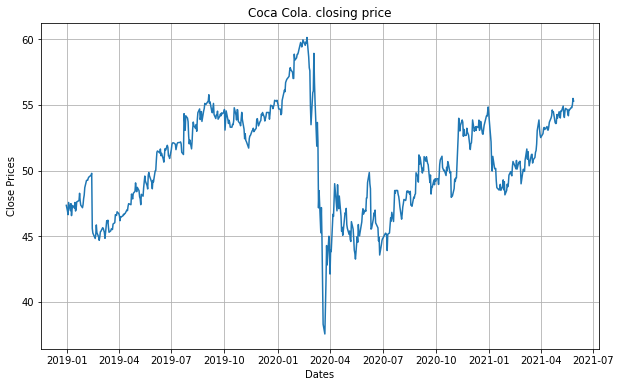

In [4]:
#可視化股票的每日收盤價
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(CocaCola['Close'])
plt.title('Coca Cola. closing price')
plt.show()

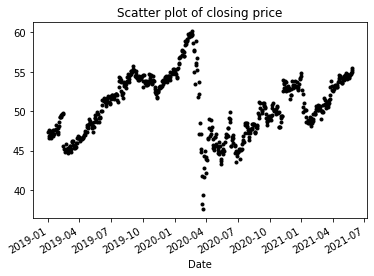

In [5]:
# 散點圖
CocaCola_close = CocaCola['Close']
CocaCola_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

## 2. Second Section-Time Series Model

-   2.1 Use time series model to check data

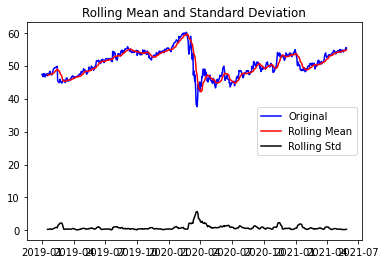

Results of dickey fuller test
Test Statistics                 -2.471511
p-value                          0.122561
No. of lags used                12.000000
Number of observations used    595.000000
critical value (1%)             -3.441388
critical value (5%)             -2.866410
critical value (10%)            -2.569363
dtype: float64


In [6]:
# Dickey-Fuller 檢驗
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(CocaCola_close)

#### 由以上Dickey-Fuller檢驗結果可知，P值為0.122561，大於0.05，因此不能拒絕Null，也就是說這個序列是不平穩的

<Figure size 432x288 with 0 Axes>

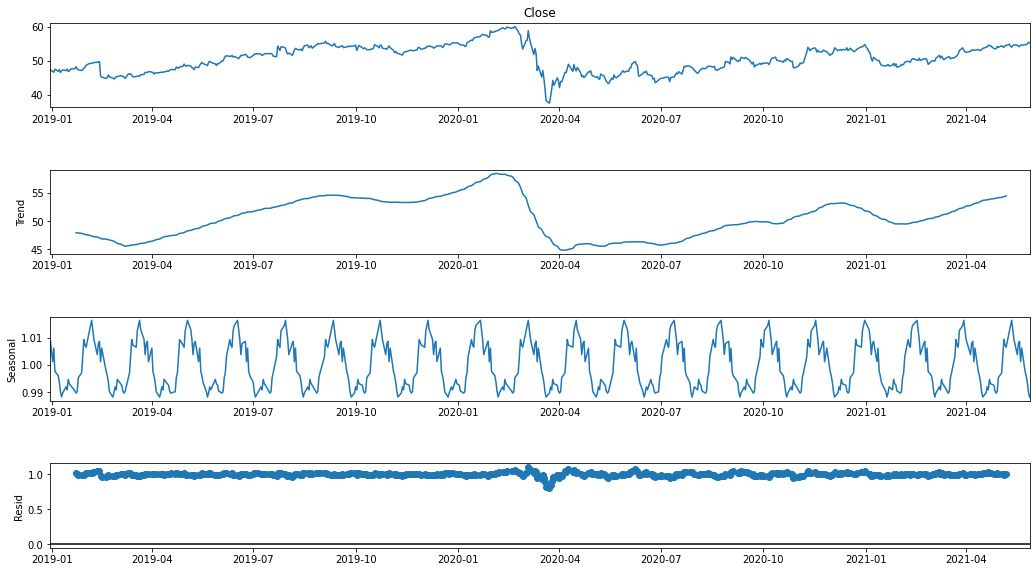

In [7]:
# 股票可能會因為每季不同的趨勢情況而導致時間序列不平穩。所以可能需要將季節分開看才會平穩
result = seasonal_decompose(CocaCola_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


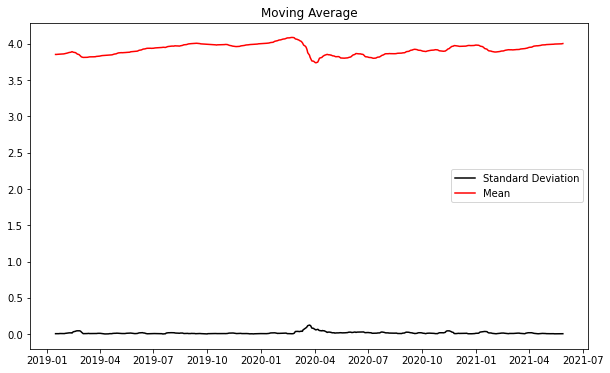

In [8]:
# 取系列的對數來減少值的大小並減少系列中的上升趨勢，可以再找到系列的滾動平均值。
# 滾動平均值的計算方法是獲取過去 12 個月的輸入，並給出連續的每個點的平均消費值。
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
CocaCola_log = np.log(CocaCola_close)
moving_avg = CocaCola_log.rolling(12).mean()
std_dev = CocaCola_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


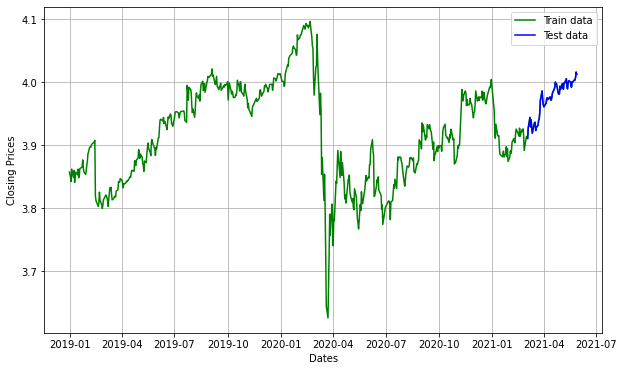

In [9]:
# 創建一個 ARIMA 模型，使用股票收盤價來訓練，將數據分為訓練和測試集
train_data, test_data = CocaCola_log[3:int(len(CocaCola_log)*0.9)], CocaCola_log[int(len(CocaCola_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(CocaCola_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [10]:
# 使用autoARIMA獲得最佳參數，並返回擬合的ARIMA模型
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2876.960, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2876.301, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2876.081, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2878.944, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2884.786, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2877.999, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2880.865, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2881.050, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2879.669, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2887.262, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2885.122, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2886.808, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2890.891, Time=0.66 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2885.226, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0

In [11]:
# Auto ARIMA 模型將 p、d 和 q 的值分別提供為 1 跟 1 和 3。(SARIMAX(1, 1, 3)

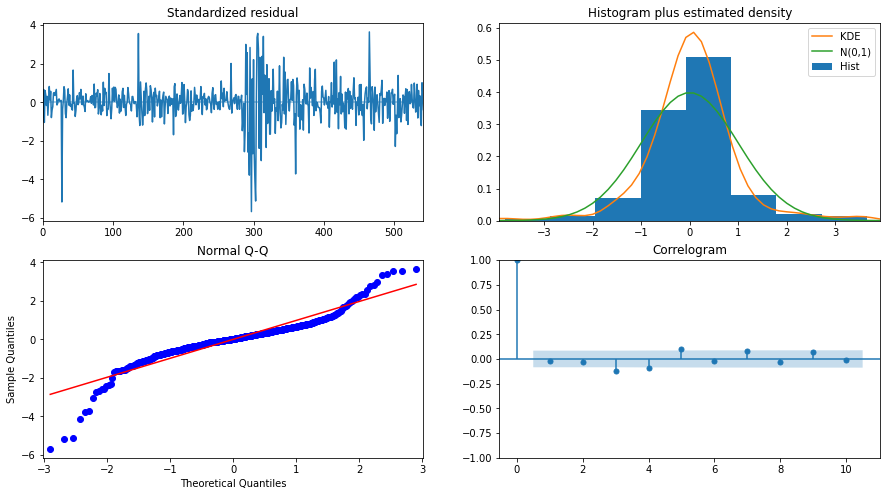

In [12]:
#  auto ARIMA 的殘差圖
model_autoARIMA.plot_diagnostics(figsize=(15,8)) 
plt.show()

In [13]:
# 再來使用提供的最佳參數p、d、q創建 ARIMA 模型。(SARIMAX(1, 1, 3))
model = ARIMA(train_data, order=(1, 1, 3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

c:\users\a9025\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\a9025\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  543
Model:                 ARIMA(1, 1, 3)   Log Likelihood                1448.649
Method:                       css-mle   S.D. of innovations              0.017
Date:                Thu, 17 Jun 2021   AIC                          -2885.298
Time:                        04:11:29   BIC                          -2859.516
Sample:                             1   HQIC                         -2875.217
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           9.41e-05      0.001      0.140      0.889      -0.001       0.001
ar.L1.D.Close     0.3127      0.207      1.512      0.131      -0.093       0.718
ma.L1.D.Close    -0.3628      0.202     

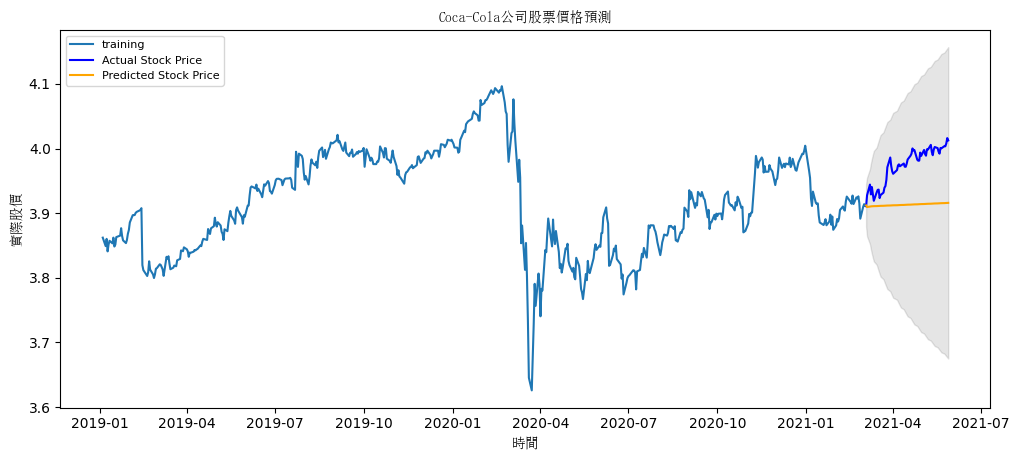

In [14]:
# 在95%置信度的測試數據上預測股票價格
fc, se, conf = fitted.forecast(61, alpha=0.05)  # 95%置信度
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Coca-Cola公司股票價格預測', fontproperties="SimSun")
plt.xlabel('時間', fontproperties="SimSun")
plt.ylabel('實際股價', fontproperties="SimSun")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
# 利用準確度指標來判斷預測結果
mse = mean_squared_error(test_data, fc)
print('MSE: ' + str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ' + str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: ' + str(mape))

MSE: 0.004412040829610961
MAE: 0.06103497603175614
RMSE: 0.06642319496690115
MAPE: 0.01531233255649142


### MAPE（平均絕對百分比誤差）大約為1.5%，也代表模型在預測測試集觀察值方面的準確度約為98.5%

## 3. Third Section – Technical Analysis
 -   RSI <br>
 -   MA <br>

#### RSI - CocaCola

In [16]:
Close=CocaCola_close
closeCocaCola=Close-Close.shift(1)
closeCocaCola=closeCocaCola.dropna()
closeCocaCola.head()

Date
2019-01-02   -0.419998
2019-01-03   -0.290001
2019-01-04    0.930000
2019-01-07   -0.619999
2019-01-08    0.529999
Name: Close, dtype: float64

In [17]:
indexprc=closeCocaCola.index
upPrc=pd.Series(0,index=indexprc)
upPrc[closeCocaCola>0]=closeCocaCola[closeCocaCola>0]
downPrc=pd.Series(0,index=indexprc)
downPrc[closeCocaCola<0]=-closeCocaCola[closeCocaCola<0]
rsidata=pd.concat([Close,closeCocaCola,upPrc,downPrc],axis=1)
rsidata.columns=['Close','closeChange','upPrc','downPrc']
rsidata=rsidata.dropna()
rsidata.head()

,Close,closeChange,upPrc,downPrc
Date,,,,
2019-01-02,46.930000,-0.419998,0.000000,0.419998
2019-01-03,46.639999,-0.290001,0.000000,0.290001
2019-01-04,47.570000,0.930000,0.930000,0.000000
2019-01-07,46.950001,-0.619999,0.000000,0.619999
2019-01-08,47.480000,0.529999,0.529999,0.000000


In [18]:
SMUP=[]
SMDOWN=[]
for i in range(6,len(upPrc)+1):
    SMUP.append(np.mean(upPrc.values[(i-6):i],dtype=np.float32))
    SMDOWN.append(np.mean(downPrc.values[(i-6):i],dtype=np.float32))

In [19]:
rsi6=[100*SMUP[i]/(SMUP[i]+SMDOWN[i]) for i in range(len(SMUP))]

In [20]:
indexRsi=indexprc[5:]
Rsi6=pd.Series(rsi6,index=indexRsi)
Rsi6.head()
Rsi6.describe()

count    602.000000
mean      55.983786
std       23.029223
min        0.000000
25%       39.492294
50%       56.151442
75%       72.420611
max      100.000000
dtype: float64

In [21]:
def rsi(price,period=6):
    import pandas as pd
    closeDif=(price-price.shift(1)).dropna()
    upPrc=pd.Series(0,index=closeDif.index)
    upPrc[closeDif>0]=closeDif[closeDif>0]
    downPrc=pd.Series(0,index=closeDif.index)
    downPrc[closeDif<0]=-closeDif[closeDif<0]
    rsi=[]
    for i in range(period,len(upPrc)+1):
        up_mean = np.mean(upPrc.values[(i-period):i],\
        dtype=np.float32)
        up_down = np.mean(downPrc.values[(i-period):i],\
        dtype=np.float32)
        rsi.append(100*up_mean/(up_mean+up_down))
    rsi=pd.Series(rsi,index=closeDif.index[(period-1):])
    return(rsi)

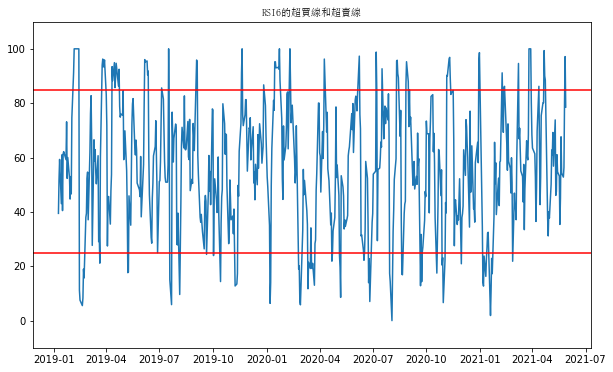

In [22]:
plt.plot(Rsi6)
plt.title('RSI6的超買線和超賣線', fontproperties="SimSun")
plt.ylim(-10,110)
plt.axhline(y=85,color='red')
plt.axhline(y=25,color='red')
plt.show()

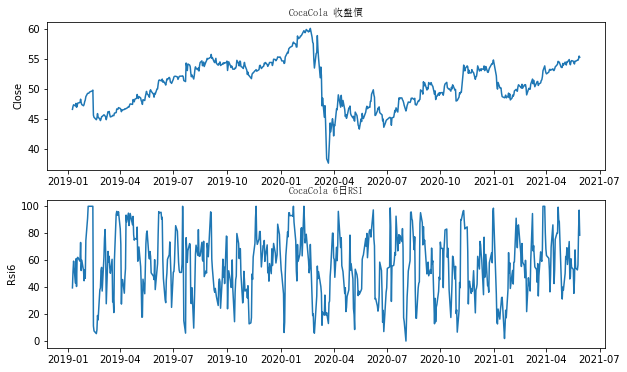

In [23]:
#收盤價和6日RSI的曲線圖
plt.subplot(211)
plt.plot(Close[Rsi6.index])
plt.ylabel('Close')
plt.title('CocaCola 收盤價', fontproperties="SimSun")

plt.subplot(212)
plt.plot(Rsi6)
plt.ylabel('Rsi6')
plt.title('CocaCola 6日RSI', fontproperties="SimSun")
plt.show()

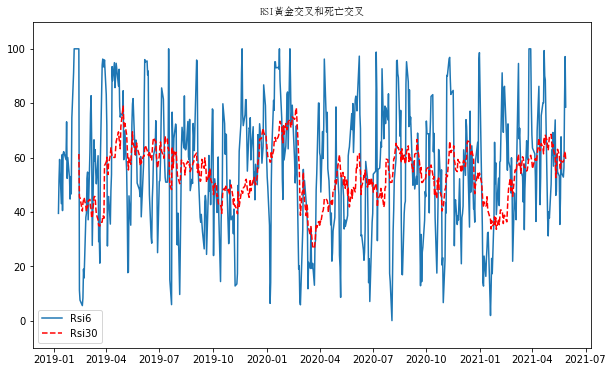

In [24]:
#黃金交叉和死亡交叉
Rsi30=rsi(Close,30)
Rsi30.tail()

plt.plot(Rsi6,label='Rsi6')
plt.plot(Rsi30,
         label='Rsi30',color='red',\
         linestyle='dashed')
plt.title('RSI黃金交叉和死亡交叉', fontproperties="SimSun")
plt.ylim(-10,110)
plt.legend()
plt.show()

#### 計算買賣信號準確率

In [25]:
#strategy
CocaCola.index=pd.to_datetime(CocaCola.index)
Close =CocaCola.Close
rsi6=rsi(Close,6)
rsi30=rsi(Close,30)

In [26]:
#rsi6捕捉買賣點
Sig1=[]
for i in rsi6:
    if i>90:
        Sig1.append(-1)
    elif i<10:
        Sig1.append(1)
    else:
        Sig1.append(0)

In [27]:
date1=rsi6.index
Signal1=pd.Series(Sig1,index=date1)
Signal1[Signal1==1].head(n=3)
Signal1[Signal1==-1].head(n=3)

Date
2019-02-04   -1
2019-02-05   -1
2019-02-06   -1
dtype: int64

In [28]:
Signal2=pd.Series(0,index=rsi30.index)
lagrsi6= rsi6.shift(1)
lagrsi30= rsi30.shift(1)
for i in rsi30.index:
    if (rsi6[i]>rsi30[i]) & (lagrsi6[i]<lagrsi30[i]):
        Signal2[i]=1
    elif (rsi6[i]<rsi30[i]) & (lagrsi6[i]>lagrsi30[i]):
        Signal2[i]=-1

In [29]:
signal=Signal1+Signal2
signal[signal==2] = 1
signal[signal==-2] = -1
signal=signal.dropna()

In [30]:
tradSig=signal.shift(1)

In [31]:
ret=Close/Close.shift(1)-1
ret.head()

Date
2018-12-31         NaN
2019-01-02   -0.008870
2019-01-03   -0.006179
2019-01-04    0.019940
2019-01-07   -0.013033
Name: Close, dtype: float64

In [32]:
ret=ret[tradSig.index]
buy=tradSig[tradSig==1]
buyRet=ret[tradSig==1]*buy

In [33]:
sell=tradSig[tradSig==-1]
sellRet=ret[tradSig==-1]*sell

tradeRet=ret*tradSig

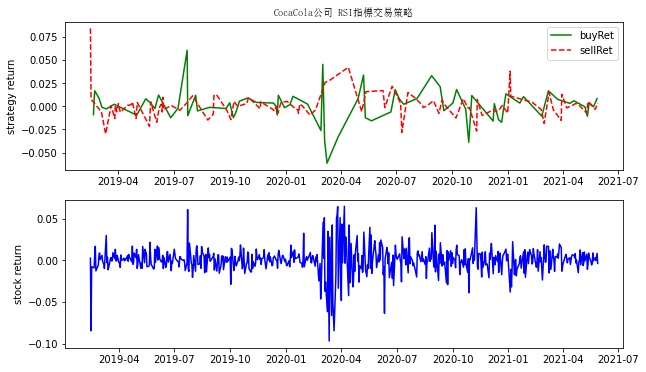

In [34]:
plt.subplot(211)
plt.plot(buyRet,label='buyRet',color='g')
plt.plot(sellRet,label='sellRet',
    color='r',linestyle='dashed')
plt.title('CocaCola公司 RSI指標交易策略', fontproperties="SimSun")
plt.ylabel('strategy return')
plt.legend()
plt.subplot(212)
plt.plot(ret,'b')
plt.ylabel('stock return')
plt.show()

In [35]:
def strat(tradeSignal,ret):
    ret=ret[tradeSignal.index]
    tradeRet=ret*tradeSignal
    tradeRet[tradeRet==(-0)]=0
    winRate=len(tradeRet[tradeRet>0])/len(\
           tradeRet[tradeRet!=0])
    meanWin=sum(tradeRet[tradeRet>0])/len(\
            tradeRet[tradeRet>0])
    meanLoss=sum(tradeRet[tradeRet<0])/len(\
             tradeRet[tradeRet<0])
    perform={'winRate':winRate,\
    'meanWin':meanWin,\
    'meanLoss': meanLoss}
    return(perform)

BuyOnly=strat(buy,ret)
SellOnly=strat(sell,ret)
Trade=strat(tradSig,ret)
Test=pd.DataFrame({"BuyOnly":BuyOnly,\
        "SellOnly":SellOnly,"Trade":Trade})
Test

,BuyOnly,SellOnly,Trade
winRate,0.555556,0.533981,0.539773
meanWin,0.011808,0.009685,0.010579
meanLoss,-0.012413,-0.008206,-0.009889


Text(0.5, 1.0, 'RSI指標交易策略累積收益率')

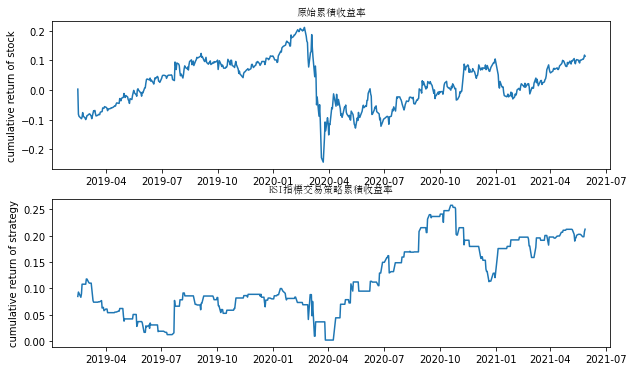

In [36]:
# 累計收益率
cumStock=np.cumprod(1+ret)-1
cumTrade=np.cumprod(1+tradeRet)-1

plt.subplot(211)
plt.plot(cumStock)
plt.ylabel('cumulative return of stock')
plt.title('原始累積收益率', fontproperties="SimSun")
plt.subplot(212)
plt.plot(cumTrade)
plt.ylabel('cumulative return of strategy')
plt.title('RSI指標交易策略累積收益率', fontproperties="SimSun")

-   2.2 Use Pair Trading to Choose the best pairs

這邊使用百事可樂公司(PEP)與可口可樂公司(KO)做配對交易

In [37]:
from pandas_datareader import data as pdr
import datetime
from statsmodels.tsa.stattools import coint, adfuller
import seaborn
import statsmodels.api as sm

In [38]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [39]:
# 獲取2016~2021年百事可樂公司(PEP)與可口可樂公司(KO)的股票定價數據
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2021, 1, 1)

tickers = ['KO', 'PEP']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

Symbols,KO,PEP
Date,,
2020-12-24,53.439999,145.059998
2020-12-28,54.160000,146.910004
2020-12-29,54.130001,147.419998
2020-12-30,54.439999,147.309998
2020-12-31,54.840000,148.300003


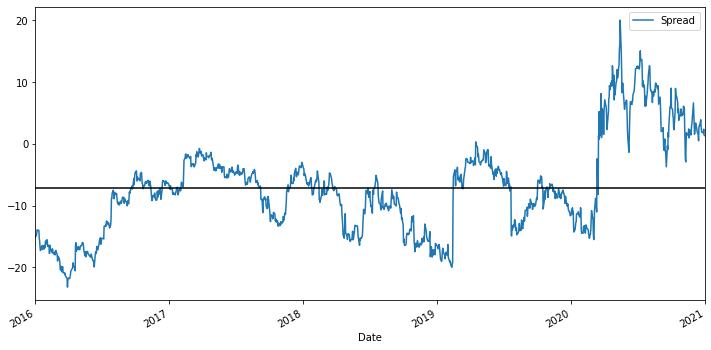

In [40]:
# 計算實際價差
S1 = df['KO']
S2 = df['PEP']

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['KO']
b = results.params['KO']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2016-01-01', '2021-01-01')
plt.legend(['Spread']);

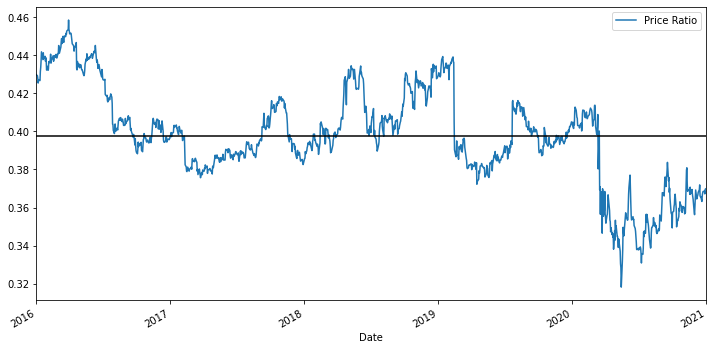

In [41]:
# 檢查兩個時間序列之間的比率
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2016-01-01', '2021-01-01')
plt.legend(['Price Ratio']);

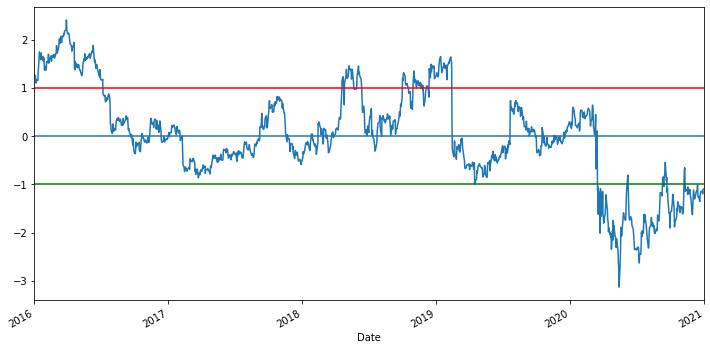

In [42]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2016-01-01', '2021-01-01')
plt.show()

通過在z分數(zscore)1和-1處設置另外兩條線，可以看到在大多數情況下，與平均值的相反數值最終都會收斂

#### MA - (CocaCola & PepsiCo交替買賣)

In [43]:
# 訓練、測試資料切割，比率為70%和30%
ratios = df['KO'] / df['PEP'] 
print(len(ratios) * .70 )

882.0


In [44]:
train = ratios[:882]
test = ratios[882:]

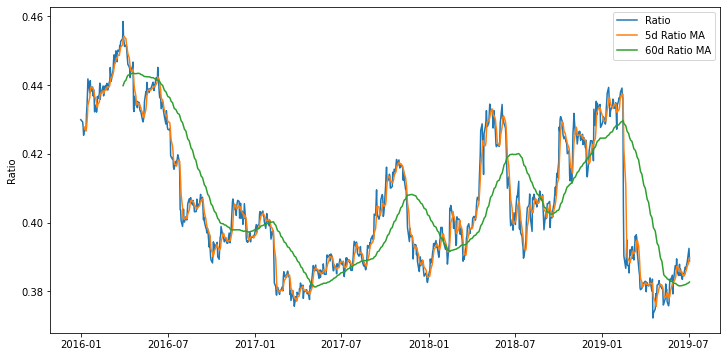

In [45]:
# 畫出比率的60、5天移動平均線與60天標準差和z score
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

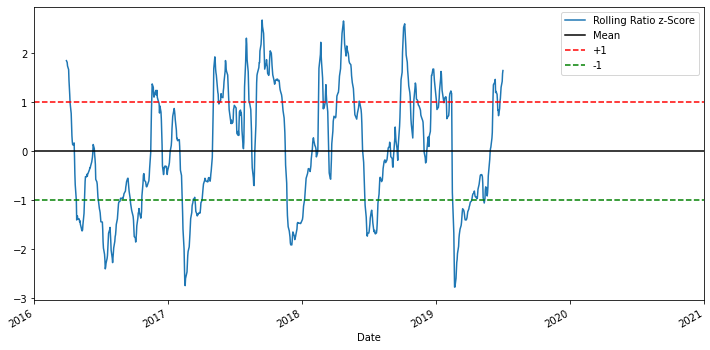

In [46]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2016-01-01', '2021-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

### 創建模型
#### 標準正態分佈的均值為 0，標準差為 1。
#### 從圖中可以看出如果時間序列超出均值1個標準差，會趨向於回歸均值
#### 可以創建以下交易信號： 每當z-score低於-1時買入、z-score高於1時賣出

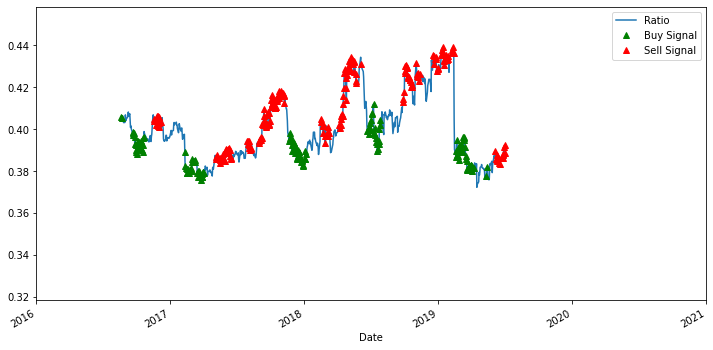

In [47]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2016-01-01','2021-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

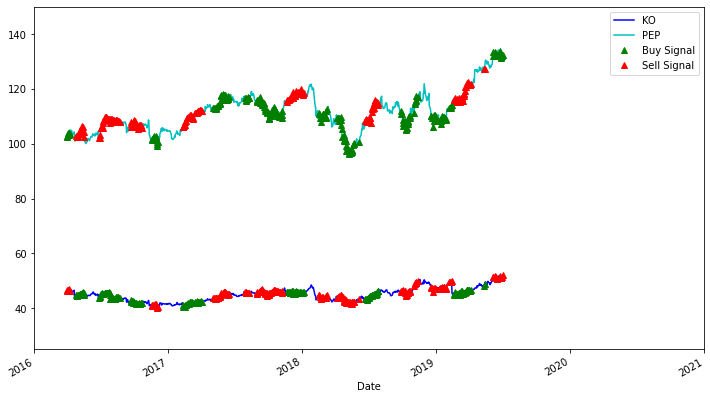

In [48]:
plt.figure(figsize=(12,7))
S1 = df['KO'].iloc[:881]
S2 = df['PEP'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 150)
plt.xlim('2016-01-01', '2021-01-01')

plt.legend(['KO', 'PEP', 'Buy Signal', 'Sell Signal'])
plt.show()

### 可以透過上圖知道應該何時買入或賣出對應的股票

## 4. Final SectionMake own Trading Strategy

In [49]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [50]:
trade(df['KO'].iloc[881:], df['PEP'].iloc[881:], 60, 5)

175.74429848000045

### 數據期間為:2016-01-01~2021-01-01(五年)，拆分為70%、30% <br>
### 訓練為:3.5年、測試為:1.5年 <br>
### 估計利潤為:175.74(美元)